In [1]:
# This cell installs all necessary libraries for the project.
!pip install -q pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm shap requests openpyxl

In [2]:
# =============== 0) Imports & Global Setup ===============
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import requests
import pickle
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# SHAP
import shap

# Colab-specific file handling
from google.colab import userdata

# =============== 1) Configuration ===============
# Fetch API key from Colab Secrets.
# If the key is not found, weather enrichment will be skipped.
try:
    VC_API_KEY = userdata.get('VC_API_KEY')
    USE_WEATHER = True
    print("✅ Visual Crossing API Key found. Weather enrichment is ENABLED.")
except:
    VC_API_KEY = ""
    USE_WEATHER = False
    print("⚠️ Visual Crossing API Key not found in Colab Secrets. Weather enrichment is DISABLED.")


# Cities & date window: adjust based on API quota
# Note: A longer date range will use more of your daily API quota.
CITIES = [
    "Bengaluru, IN",
    "Delhi, IN",
    "London, UK",
    "Singapore"
]
WEATHER_START = "2023-01-01"
WEATHER_END   = "2023-01-12"  # Keep short to respect free quota

# Emission factor (kg CO2 per kWh)
EMISSION_FACTOR = 0.233

# UCI dataset URL
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"

# Paths for saved files in the Colab environment
ARTIFACTS_DIR = "artifacts"
FIGURES_DIR = "figures"
DATA_DIR = "data"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
UCI_PATH = os.path.join(DATA_DIR, "ENB2012_data.xlsx")


# Reproducibility
RNG = 42
np.random.seed(RNG)

⚠️ Visual Crossing API Key not found in Colab Secrets. Weather enrichment is DISABLED.


In [3]:
# =============== 2) Helpers ===============

def download_uci_if_needed():
    """Downloads the UCI dataset if it doesn't already exist."""
    if not os.path.exists(UCI_PATH):
        print("Downloading UCI Energy Efficiency dataset…")
        try:
            r = requests.get(UCI_URL, timeout=30)
            r.raise_for_status()
            with open(UCI_PATH, "wb") as f:
                f.write(r.content)
            print("✅ UCI dataset downloaded successfully.")
        except requests.exceptions.RequestException as e:
            print(f"❌ Failed to download dataset: {e}")
            raise
    else:
        print("UCI dataset already present.")


def get_visual_crossing_daily(city: str, start_date: str, end_date: str, key: str,
                              unit_group: str = "metric",
                              elements: str = "datetime,temp,humidity,dew,precip,pressure,cloudcover,solarradiation,windspeed" ) -> pd.DataFrame:
    """Fetches daily weather data from the Visual Crossing timeline API."""
    base = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/{start_date}/{end_date}"
    params = {
        "unitGroup": unit_group, "key": key, "include": "days",
        "elements": elements, "contentType": "json",
    }
    try:
        resp = requests.get(base, params=params, timeout=60)
        resp.raise_for_status()
        js = resp.json()
        rows = []
        for d in js.get("days", []):
            row = {k: d.get(k, np.nan) for k in elements.split(',')}
            row["city"] = js.get("resolvedAddress").split(',')[0] # Use resolved city name
            rows.append(row)
        df = pd.DataFrame(rows)
        if not df.empty:
            df["date"] = pd.to_datetime(df["datetime"]).dt.date
            df.drop(columns=["datetime"], inplace=True)
        return df
    except requests.exceptions.RequestException as e:
        print(f"❌ Could not fetch weather for {city}: {e}")
        return pd.DataFrame()


def compute_hdd_cdd(temp_c: pd.Series, base_c: float = 18.0) -> pd.DataFrame:
    """Computes Heating and Cooling Degree Days (HDD/CDD)."""
    hdd = np.maximum(0, base_c - temp_c)
    cdd = np.maximum(0, temp_c - base_c)
    return pd.DataFrame({"HDD": hdd, "CDD": cdd})

In [4]:
# =============== 3) Load & Clean UCI Building Data ===============
download_uci_if_needed()
uci = pd.read_excel(UCI_PATH)
uci.columns = [
    'Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
    'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution',
    'Heating_Load', 'Cooling_Load'
]

# Basic checks & type casting
assert uci.isna().sum().sum() == 0, "UCI dataset unexpectedly has missing values."
uci['Orientation'] = uci['Orientation'].astype(int)
uci['Glazing_Area_Distribution'] = uci['Glazing_Area_Distribution'].astype(int)

# Create combined target variables
uci['Energy_Usage_kWh'] = uci['Heating_Load'] + uci['Cooling_Load']
uci['Carbon_Emissions_kg'] = uci['Energy_Usage_kWh'] * EMISSION_FACTOR

print("UCI Data Loaded. Shape:", uci.shape)
print("Sample of Building Data:")
uci.head()

✅ UCI dataset downloaded successfully.
UCI Data Loaded. Shape: (768, 12)
Sample of Building Data:


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load,Energy_Usage_kWh,Carbon_Emissions_kg
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,36.88,8.59304
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,36.88,8.59304
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,36.88,8.59304
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,36.88,8.59304
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,49.12,11.44496


In [5]:
# =============== 4) Weather Data Merge ===============
if USE_WEATHER:
    print("Fetching weather data from Visual Crossing…")
    weather_frames = []
    for city in CITIES:
        print(f"  -> Fetching for {city} from {WEATHER_START} to {WEATHER_END}")
        dfw = get_visual_crossing_daily(city, WEATHER_START, WEATHER_END, VC_API_KEY)
        if not dfw.empty:
            weather_frames.append(dfw)
        time.sleep(1) # Be respectful to the API

    if weather_frames:
        weather = pd.concat(weather_frames, ignore_index=True)

        # Engineer HDD/CDD
        hddcdd = compute_hdd_cdd(weather['temp'])
        weather = pd.concat([weather, hddcdd], axis=1)

        # Interpolate to fill any minor gaps in weather data
        weather_cols_to_fill = ['humidity','dew','precip','pressure','cloudcover','solarradiation','windspeed','HDD','CDD']
        for c in weather_cols_to_fill:
            if c in weather.columns:
                weather[c] = weather[c].astype(float).interpolate().bfill().ffill()

        # Create a Cartesian product (each building blueprint for each city/date)
        uci['_key'] = 1
        city_dates = weather[['city', 'date']].drop_duplicates().copy()
        city_dates['_key'] = 1
        expanded = uci.merge(city_dates, on='_key', how='left').drop(columns=['_key'])

        # Join the weather data to the expanded building data
        data_merged = expanded.merge(weather, on=['city','date'], how='left')
    else:
        print("Weather fetching failed for all cities. Proceeding without weather data.")
        USE_WEATHER = False # Flip flag to fallback

# Fallback if weather is disabled or failed
if not USE_WEATHER:
    print("Skipping weather enrichment. Using building data only with placeholder values.")
    uci['city'] = 'NoWeather'
    uci['date'] = pd.to_datetime('2023-01-01').date()
    for c in ['temp','humidity','dew','precip','pressure','cloudcover','solarradiation','windspeed']:
        uci[c] = np.nan
    uci[['HDD','CDD']] = compute_hdd_cdd(pd.Series([18.0] * len(uci))) # Assume base temp
    data_merged = uci.copy()

print("\nFinal Merged Data Shape:", data_merged.shape)
print("Sample of Merged Data:")
data_merged.head()

Skipping weather enrichment. Using building data only with placeholder values.

Final Merged Data Shape: (768, 24)
Sample of Merged Data:


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load,...,temp,humidity,dew,precip,pressure,cloudcover,solarradiation,windspeed,HDD,CDD
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


Generating and saving EDA plots…


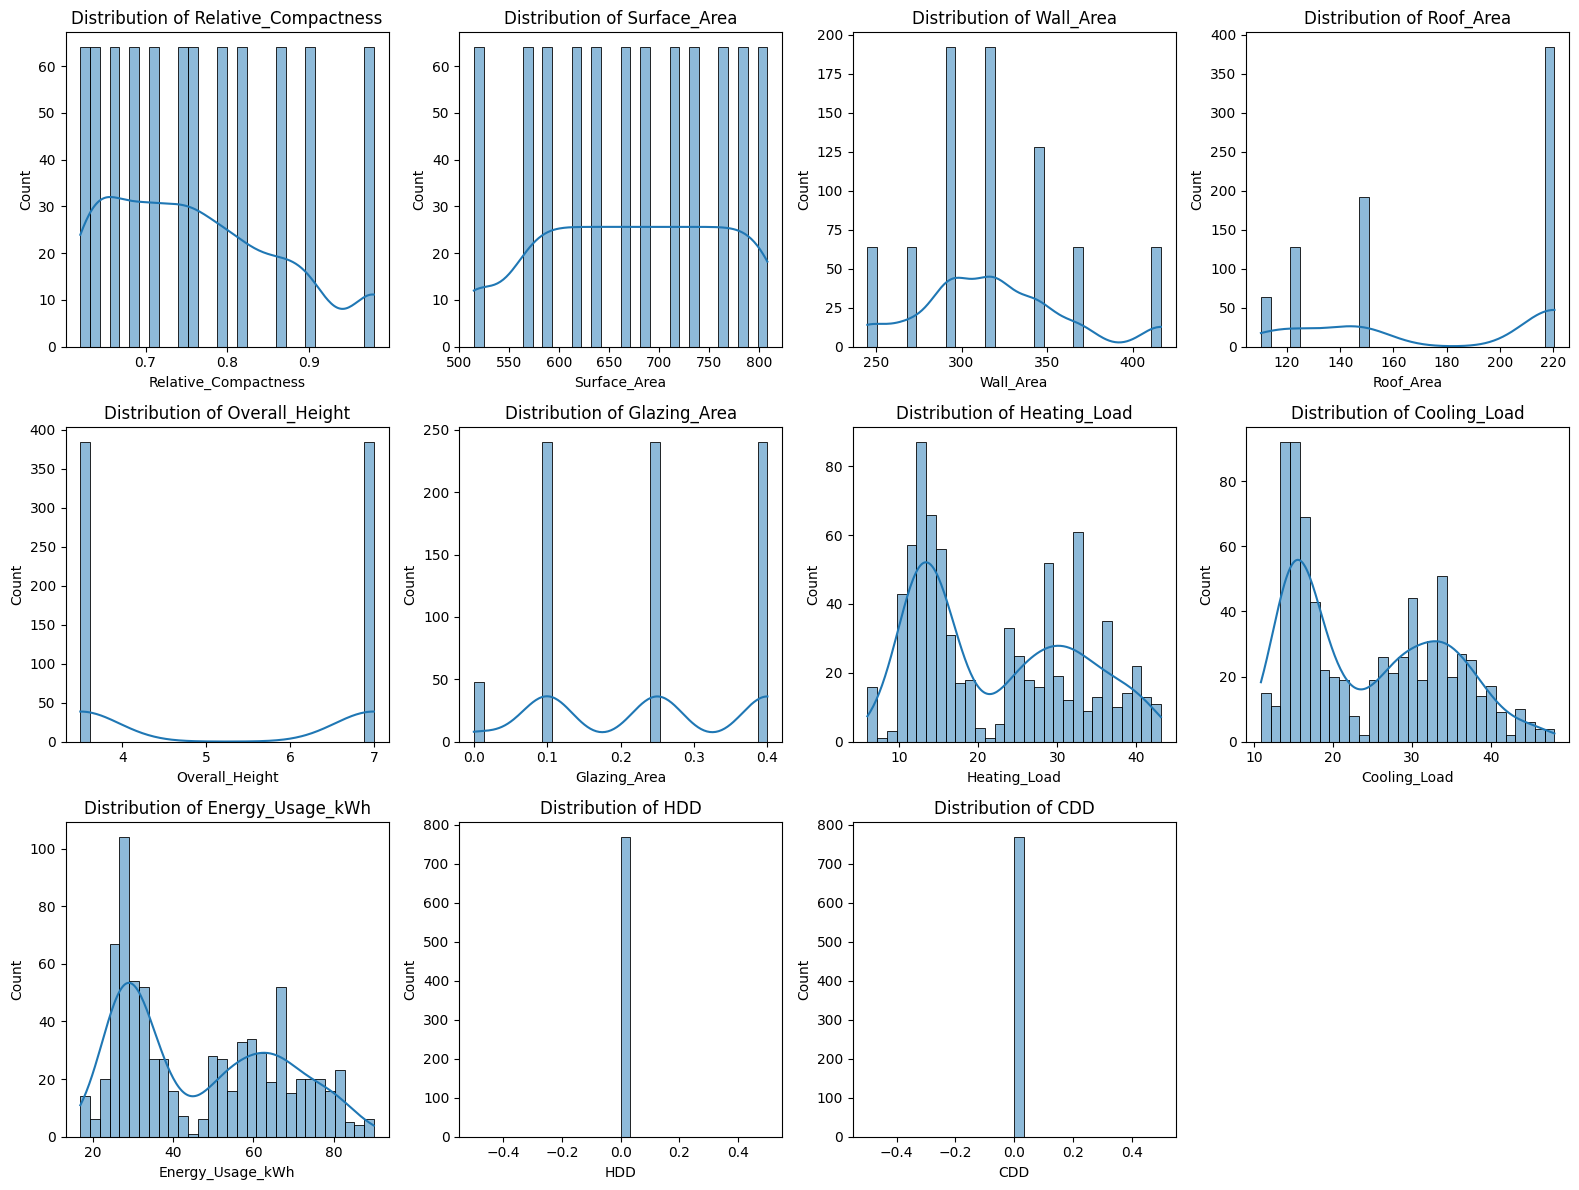

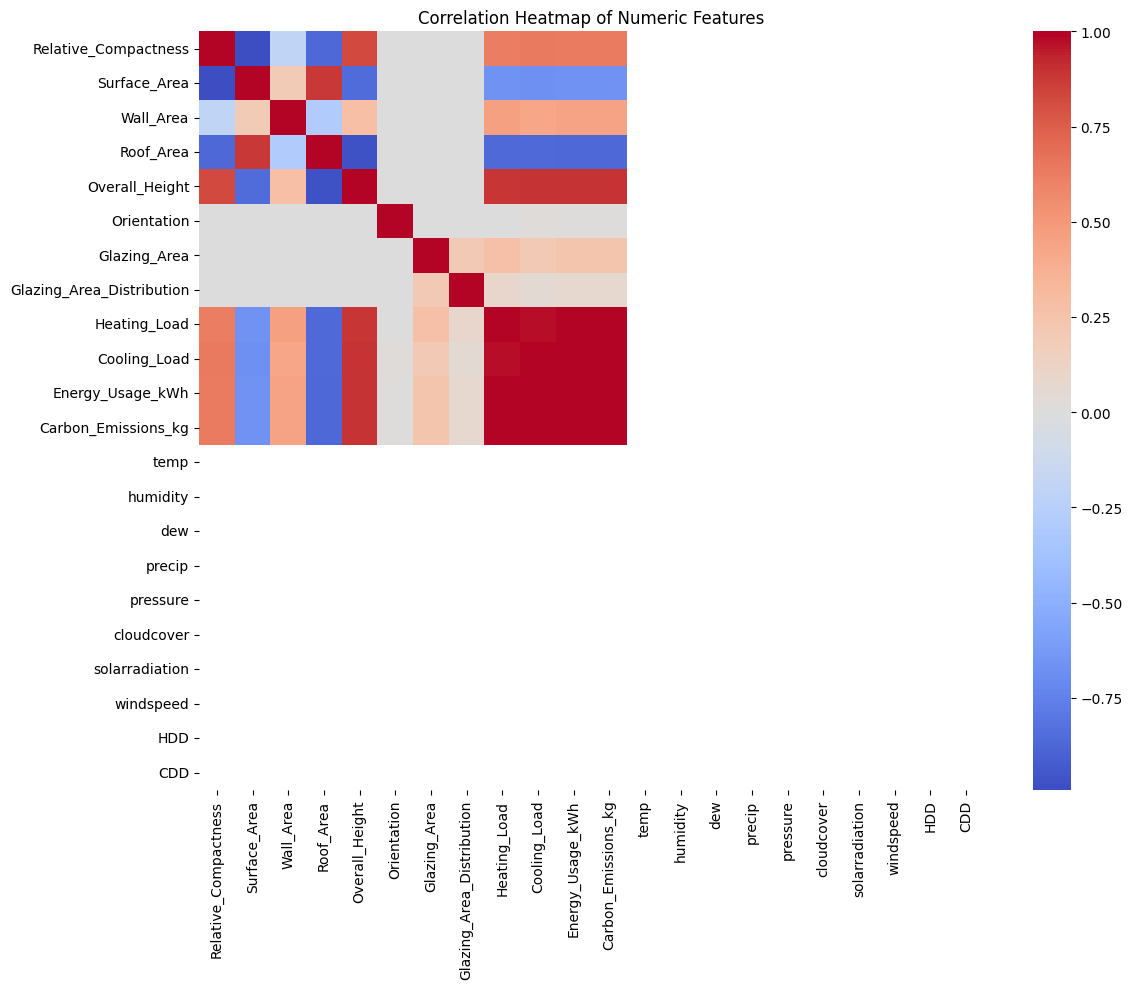

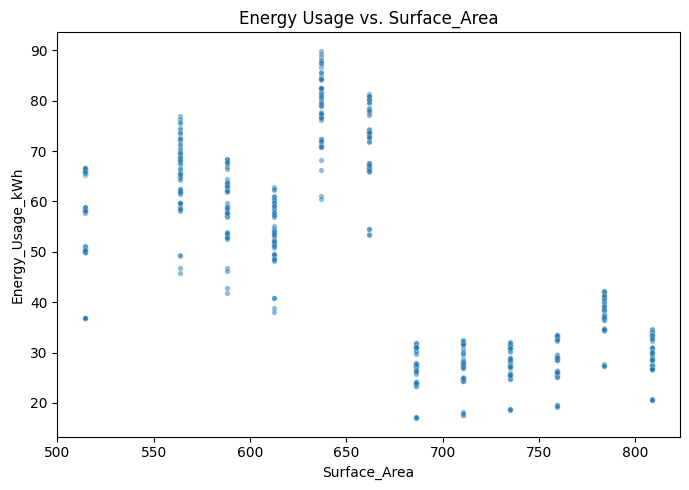

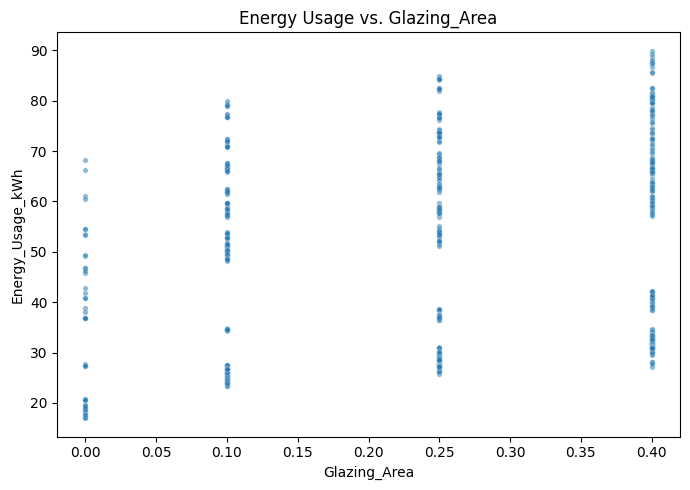

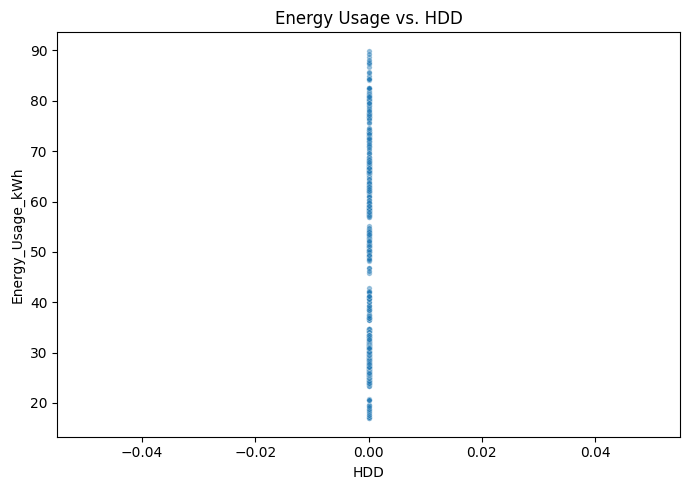

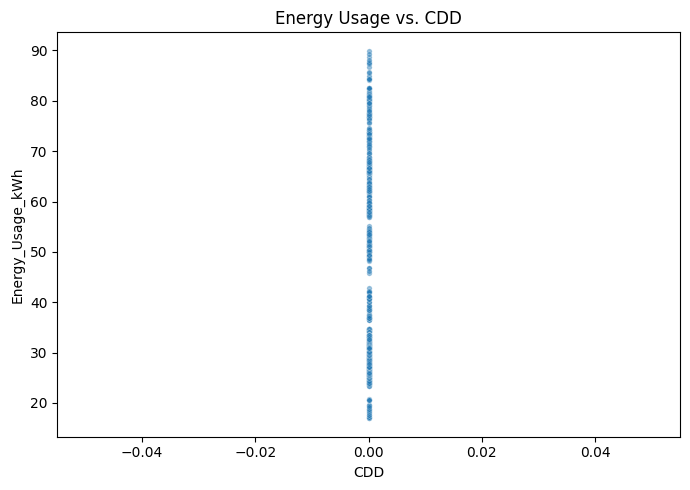

In [6]:
# =============== 5) Exploratory Data Analysis ===============
print("Generating and saving EDA plots…")

# --- Distributions of Key Numeric Features ---
num_cols_eda = [
    'Relative_Compactness','Surface_Area','Wall_Area','Roof_Area','Overall_Height','Glazing_Area',
    'Heating_Load','Cooling_Load','Energy_Usage_kWh','temp','humidity','solarradiation','HDD','CDD'
]
plt.figure(figsize=(16, 12))
for i, col in enumerate([c for c in num_cols_eda if c in data_merged.columns and data_merged[c].notna().any()][:12]):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data_merged[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "01_distributions.png"), dpi=120)
plt.show()


# --- Correlation Heatmap ---
num_corr_cols = data_merged.select_dtypes(include=np.number).columns
corr = data_merged[num_corr_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "02_corr_heatmap.png"), dpi=120)
plt.show()


# --- Scatter Plots of Features vs. Target ---
for col in ['Surface_Area', 'Glazing_Area', 'temp', 'solarradiation', 'HDD', 'CDD']:
    if col in data_merged.columns and data_merged[col].notna().any():
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=data_merged, x=col, y='Energy_Usage_kWh', s=15, alpha=0.5)
        plt.title(f'Energy Usage vs. {col}')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, f"03_scatter_energy_{col}.png"), dpi=120)
        plt.show()

In [7]:
# =============== 6) Modeling Data Prep ===============
# Define features and target
FEATURES = [
    'Relative_Compactness','Surface_Area','Wall_Area','Roof_Area','Overall_Height',
    'Orientation','Glazing_Area','Glazing_Area_Distribution',
    'temp','humidity','dew','precip','pressure','cloudcover','solarradiation','windspeed','HDD','CDD','city'
]
FEATURES = [c for c in FEATURES if c in data_merged.columns] # Use only available columns
TARGET = 'Energy_Usage_kWh'

# Create the final modeling dataframe
model_df = data_merged[FEATURES + [TARGET]].copy().dropna(subset=[TARGET])

X = model_df[FEATURES]
y = model_df[TARGET]

# Define numeric & categorical feature sets for preprocessing
num_feats = X.select_dtypes(include=np.number).columns.tolist()
cat_feats = X.select_dtypes(exclude=np.number).columns.tolist()

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines into a single preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)
    ],
    remainder='passthrough'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape:  X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(614, 19), y_train=(614,)
Testing data shape:  X_test=(154, 19), y_test=(154,)


In [8]:
# =============== 7) Model Zoo ===============
# Define a dictionary of models to train
models = {
    'Linear': Pipeline([('pre', preprocess), ('est', LinearRegression())]),
    'Ridge': Pipeline([('pre', preprocess), ('est', Ridge(random_state=RNG))]),
    'Lasso': Pipeline([('pre', preprocess), ('est', Lasso(alpha=0.01, max_iter=10000, random_state=RNG))]),
    'RandomForest': Pipeline([('pre', preprocess), ('est', RandomForestRegressor(n_estimators=100, random_state=RNG, n_jobs=-1))]),
    'GBM': Pipeline([('pre', preprocess), ('est', GradientBoostingRegressor(random_state=RNG))]),
    'XGB': Pipeline([('pre', preprocess), ('est', XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=RNG, n_jobs=-1))]),
    'LightGBM': Pipeline([('pre', preprocess), ('est', LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=RNG, n_jobs=-1))]),
    'MLP': Pipeline([('pre', preprocess), ('est', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=RNG))]),
}

# Define a more complex stacking ensemble model
stack = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=RNG, n_jobs=-1)),
        ('lgb', LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=RNG, n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)
models['Stacking'] = Pipeline([('pre', preprocess), ('est', stack)])

print(f"Defined {len(models)} models for training.")

Defined 9 models for training.


In [9]:
# =============== NEW SECTION: Hyperparameter Tuning ===============
print("Proceeding to hyperparameter tuning for the best model candidates...")

# We'll tune the LightGBM pipeline.
lgbm_pipeline = models['LightGBM']

# Define the grid of hyperparameters to search.
# The keys are in the format 'step_name__parameter_name'.
param_distributions = {
    'est__n_estimators': [200, 400, 600, 800, 1000],
    'est__learning_rate': [0.01, 0.02, 0.05, 0.1],
    'est__num_leaves': [20, 31, 40, 50, 60],
    'est__max_depth': [-1, 10, 15, 20],
    'est__reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'est__reg_lambda': [0, 0.01, 0.1, 0.5, 1],
    'est__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'est__subsample': [0.7, 0.8, 0.9, 1.0],
}

print("Defined parameter grid for LightGBM.")

Proceeding to hyperparameter tuning for the best model candidates...
Defined parameter grid for LightGBM.


In [10]:
# Instantiate RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled.
# cv: Number of cross-validation folds.
# scoring: Metric to optimize. 'neg_root_mean_squared_error' is used because CV maximizes a score.
random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # Increase for a more thorough search, decrease for speed
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RNG,
    verbose=1  # Set to 2 for more detailed output
)

print("\nRunning RandomizedSearchCV for LightGBM...")
start_time = time.time()
random_search.fit(X_train, y_train)
duration = time.time() - start_time
print(f"RandomizedSearch completed in {duration:.2f} seconds.")

# --- Display Results ---
print("\nBest Hyperparameters Found:")
print(random_search.best_params_)

print(f"\nBest Cross-Validated RMSE: {-random_search.best_score_:.4f}")


# --- Update the 'best_model' with the tuned version ---
# The best_estimator_ is already refitted on the entire training data
best_model_name = "LightGBM_Tuned"
best_model_pipeline = random_search.best_estimator_

print(f"\n🏆 New best model is '{best_model_name}'.")

# You can now proceed to evaluate this tuned model on the test set
# and generate SHAP plots for it, just as you did before.
y_pred_tuned = best_model_pipeline.predict(X_test)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_r2 = r2_score(y_test, y_pred_tuned)

print(f"\nPerformance of Tuned Model on Test Set:")
print(f"  -> RMSE: {tuned_rmse:.4f}")
print(f"  -> R²:   {tuned_r2:.4f}")


Running RandomizedSearchCV for LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] Start training from score 46.565798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [11]:
# =============== 8) Train & Evaluate ===============
metrics = []
trained_models = {}
print("Training and evaluating all models...")
print("-" * 50)

for name, pipe in models.items():
    start_time = time.time()
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    # --- FIX STARTS HERE ---
    # Calculate metrics. For older scikit-learn versions, calculate RMSE
    # by taking the square root of the mean squared error.
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))  # Corrected line
    r2 = r2_score(y_test, pred)
    # --- FIX ENDS HERE ---

    duration = time.time() - start_time

    metrics.append((name, mae, rmse, r2, duration))
    trained_models[name] = pipe
    print(f"{name:12s} | R² {r2:6.3f} | RMSE {rmse:7.3f} | MAE {mae:7.3f} | Time {duration:5.2f}s")

print("-" * 50)

# Create and save a dataframe of the metrics
metrics_df = pd.DataFrame(metrics, columns=["Model", "MAE", "RMSE", "R2", "Training_Time_s"]).sort_values("R2", ascending=False).reset_index(drop=True)
metrics_df.to_csv(os.path.join(ARTIFACTS_DIR, "metrics_energy.csv"), index=False)

# Identify and save the best model
best_model_name = metrics_df.iloc[0]['Model']
best_model_pipeline = trained_models[best_model_name]

with open(os.path.join(ARTIFACTS_DIR, "best_energy_model.pkl"), "wb") as f:
    pickle.dump(best_model_pipeline, f)

print(f"\n🏆 Best model is '{best_model_name}'. Model saved.")
print("\nTop 5 Models by R² Score:")
print(metrics_df.head())

Training and evaluating all models...
--------------------------------------------------
Linear       | R²  0.913 | RMSE   5.799 | MAE   4.193 | Time  0.03s
Ridge        | R²  0.913 | RMSE   5.818 | MAE   4.202 | Time  0.02s
Lasso        | R²  0.913 | RMSE   5.808 | MAE   4.197 | Time  0.02s
RandomForest | R²  0.992 | RMSE   1.718 | MAE   1.090 | Time  0.22s
GBM          | R²  0.994 | RMSE   1.478 | MAE   1.055 | Time  0.11s
XGB          | R²  0.998 | RMSE   0.872 | MAE   0.612 | Time  0.69s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] Start training from score 46.565798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Generating diagnostic plots for the best model: 'XGB'...


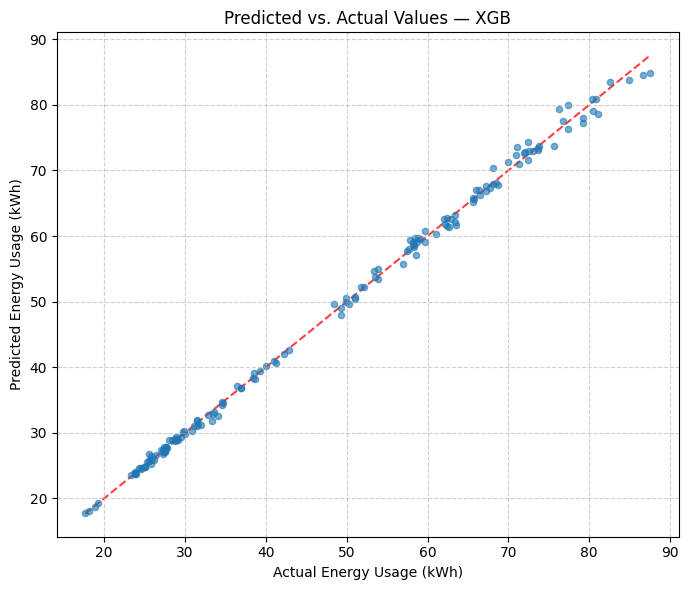

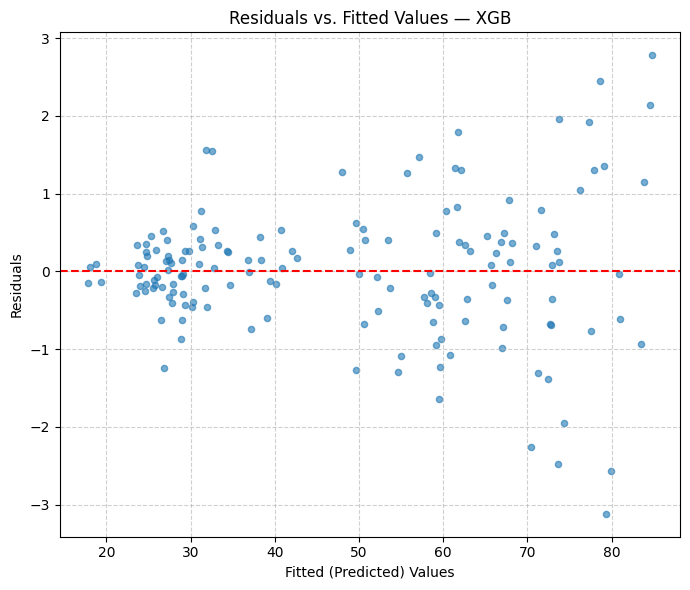

In [12]:
# =============== 9) Diagnostics Plots for Best Model ===============
print(f"Generating diagnostic plots for the best model: '{best_model_name}'...")
y_pred = best_model_pipeline.predict(X_test)
residuals = y_test - y_pred

# --- Predicted vs. Actual Plot ---
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0) # Add a reference line
plt.xlabel('Actual Energy Usage (kWh)')
plt.ylabel('Predicted Energy Usage (kWh)')
plt.title(f'Predicted vs. Actual Values — {best_model_name}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "04_pred_vs_actual.png"), dpi=120)
plt.show()

# --- Residuals vs. Fitted Plot ---
plt.figure(figsize=(7, 6))
plt.scatter(y_pred, residuals, alpha=0.6, s=20)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Fitted (Predicted) Values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted Values — {best_model_name}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "05_residuals.png"), dpi=120)
plt.show()

Generating SHAP explainability plots...


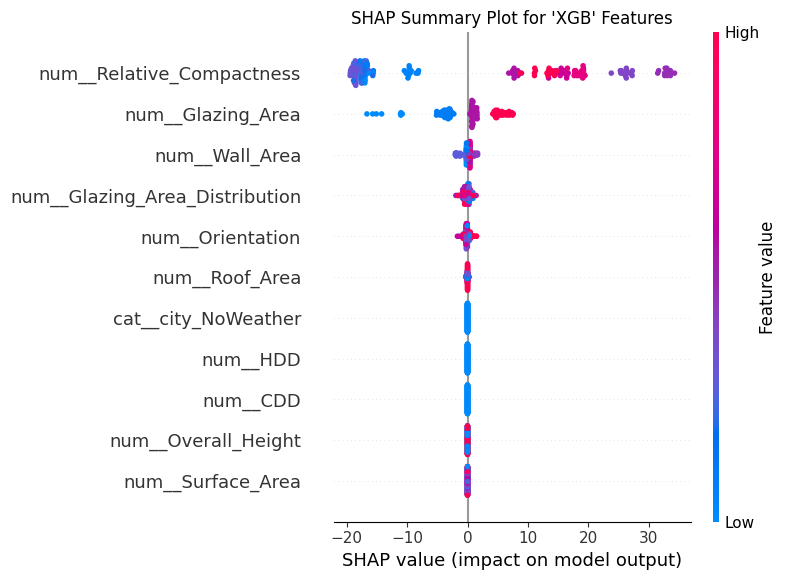

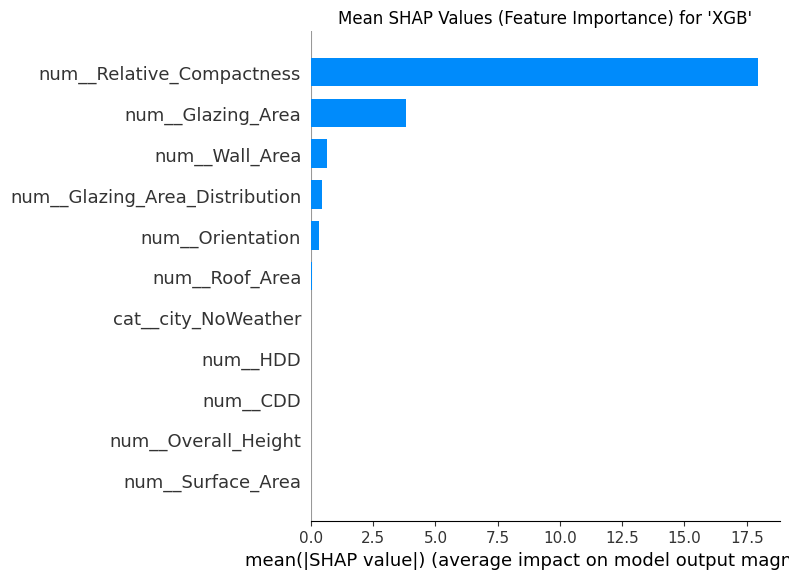

In [13]:
# =============== 10) Explainability (SHAP + Permutation) ===============
print("Generating SHAP explainability plots...")
# Use a smaller sample for SHAP to speed up computation
X_sample = X_test.sample(min(500, len(X_test)), random_state=RNG)

try:
    est = best_model_pipeline.named_steps['est']
    preprocessor = best_model_pipeline.named_steps['pre']

    # Get feature names after one-hot encoding
    try:
        # Modern scikit-learn
        feature_names = preprocessor.get_feature_names_out()
    except:
        # Older scikit-learn
        feature_names = num_feats + list(preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_feats))


    # Check if the model is tree-based for TreeExplainer
    is_tree_model = hasattr(est, 'feature_importances_')

    if is_tree_model:
        # --- FIX STARTS HERE ---
        # 1. Transform the sample data so its shape matches the SHAP values
        X_sample_transformed = preprocessor.transform(X_sample)

        # 2. If the transformed data is a sparse matrix, convert it to a dense numpy array
        if hasattr(X_sample_transformed, "toarray"):
            X_sample_transformed = X_sample_transformed.toarray()

        # Create a new DataFrame with the correct column names for plotting
        X_sample_transformed_df = pd.DataFrame(X_sample_transformed, columns=feature_names)
        # --- FIX ENDS HERE ---

        explainer = shap.Explainer(est, preprocessor.transform(X_train))
        shap_values = explainer(X_sample_transformed)

        # --- SHAP Summary Plot (Beeswarm) ---
        # Use the transformed data and feature names for plotting
        shap.summary_plot(shap_values, X_sample_transformed_df, show=False)
        plt.title(f"SHAP Summary Plot for '{best_model_name}' Features")
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, "07_shap_summary.png"), dpi=120)
        plt.show()

        # --- SHAP Bar Plot ---
        shap.summary_plot(shap_values, X_sample_transformed_df, plot_type="bar", show=False)
        plt.title(f"Mean SHAP Values (Feature Importance) for '{best_model_name}'")
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, "08_shap_bar.png"), dpi=120)
        plt.show()
    else:
        raise TypeError("Best model is not a tree-based model. Using Permutation Importance.")

except Exception as e:
    print(f"⚠️ SHAP plot generation failed ({e}). Falling back to Permutation Importance.")
    # Fallback remains the same
    r = permutation_importance(best_model_pipeline, X_test, y_test, n_repeats=10, random_state=RNG, n_jobs=-1)
    importances = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 8))
    importances.head(20).plot(kind='barh').invert_yaxis()
    plt.title(f"Permutation Importance — {best_model_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "09_perm_importance.png"), dpi=120)
    plt.show()

In [14]:
# =============== 11) Carbon Emission Outputs ===============
# Use the best model to predict on the test set
final_energy_pred = best_model_pipeline.predict(X_test)
# Convert energy predictions to carbon emission predictions
final_co2_pred = final_energy_pred * EMISSION_FACTOR

# Create and save a final report with true values and predictions
report = X_test.copy()
report['y_true_energy_kWh'] = y_test
report['y_pred_energy_kWh'] = final_energy_pred
report['pred_co2_kg'] = final_co2_pred
report_path = os.path.join(ARTIFACTS_DIR, "test_predictions_report.csv")
report.to_csv(report_path, index=False)

print(f"✅ Final predictions report saved to: {report_path}")
print("Sample of the final report:")
report.head()

✅ Final predictions report saved to: artifacts/test_predictions_report.csv
Sample of the final report:


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,temp,humidity,...,pressure,cloudcover,solarradiation,windspeed,HDD,CDD,city,y_true_energy_kWh,y_pred_energy_kWh,pred_co2_kg
668,0.62,808.5,367.5,220.50,3.5,2,0.40,3,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NoWeather,33.37,31.804310,7.410404
324,0.66,759.5,318.5,220.50,3.5,2,0.25,1,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NoWeather,29.56,29.296547,6.826095
624,0.98,514.5,294.0,110.25,7.0,2,0.40,3,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NoWeather,65.60,65.140022,15.177625
690,0.79,637.0,343.0,147.00,7.0,4,0.40,4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NoWeather,87.55,84.770714,19.751575
473,0.64,784.0,343.0,220.50,3.5,3,0.25,4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,NoWeather,36.45,37.186916,8.664552


In [15]:
# =============== 12) Download All Generated Files ===============
# This cell will zip the artifacts and figures directories and prompt you to download the file.

def zip_dir(directory, zip_filename):
    """Zips the contents of a directory."""
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                                           os.path.join(directory, '..')))

# Create a single zip file containing all results
zip_filename = f"Energy_Prediction_Results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in [ARTIFACTS_DIR, FIGURES_DIR]:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, '.'))

print(f"✅ All artifacts and figures have been zipped into '{zip_filename}'.")


✅ All artifacts and figures have been zipped into 'Energy_Prediction_Results_20250903_115115.zip'.


In [16]:
# Run this cell to trigger a browser download of the results zip file.
from google.colab import files

try:
    files.download(zip_filename)
except NameError:
    print("⚠️ 'zip_filename' not found. Please run the previous cell first to create the zip file.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>